In [25]:
pip install -q *.whl numpy matplotlib osparc_filecomms pandas

Note: you may need to restart the kernel to use updated packages.


In [45]:
import os
import pathlib as pl
import json
import zipfile

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas

import osparc
import osparc.api
import osparc_client
import osparc_client.models.file

import tools.maps
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [27]:
osparc_cfg = osparc.Configuration(host="10.43.103.149.nip.io:8006",
                                  username=os.environ["OSPARC_API_KEY"],
                                  password=os.environ["OSPARC_API_SECRET"])
output_dir_path = pl.Path(os.environ['DY_SIDECAR_PATH_OUTPUTS'])
output1_dir_path = output_dir_path / 'output_1'

input_dir_path = pl.Path(os.environ['DY_SIDECAR_PATH_INPUTS'])
input1_dir_path = input_dir_path / 'input_1'

map_outputs_file_path = pl.Path('map_outputs.json')

In [28]:
TEST_INPUT_FILES_DIR = 'example_r20211130-ivadomed_dataset'

In [29]:
input_images_dir_path = pl.Path(TEST_INPUT_FILES_DIR)
input_images_paths = list(input_images_dir_path.glob('*.png'))
input_metadata_paths = [path.with_suffix('.json') for path in input_images_paths]

In [30]:
def show_input_files(file_list):
    fig, axes = plt.subplots(1, len(file_list), figsize=(20,10))
    for local_file_path, ax in zip(file_list, axes):
        ax.imshow(mpimg.imread(local_file_path), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [31]:
def show_output_files(map_outputs, file_list):
    fig, axes = plt.subplots(1, len(file_list), figsize=(20,10))
 
    for map_output, file_path, ax in zip(map_outputs, file_list, axes):
        with zipfile.ZipFile(map_output['ProcessedImage']) as output_zip:
            segmented_filename = f'{file_path.stem}_seg-axonmyelin{file_path.suffix}'
            with output_zip.open(segmented_filename) as image_file:
                ax.imshow(mpimg.imread(image_file))
                ax.axis('off')
                
    plt.tight_layout()
    plt.show()

In [32]:
def upload_files(file_list):
    uploaded_files = []
    with osparc.ApiClient(osparc_cfg) as api_client:
        for local_file_path in file_list:
            uploaded_file = osparc.api.FilesApi(api_client).upload_file(                                                                                                                                                                    
                file=pl.Path(local_file_path)                                                                                                                                                                                                       
            )
            uploaded_files.append(uploaded_file)
    return uploaded_files

In [33]:
def create_map_inputs(up_file_list, metadata_file_list):
    map_inputs = []
    for uploaded_file, metadata_file in zip(up_file_list, metadata_file_list):
        metadata = json.loads(metadata_file.read_text())
        map_inputs.append({
            "input": { 
                "InputImage": {
                    "type": "file",
                    "value": json.dumps(uploaded_file.to_dict())
                },
                "PixelSize": {
                    "type": "float",
                    "value": metadata["PixelSize"][0] 
                }
            },
            "output": {
                "Morphometrics": {
                  "type": "file"
                },
                "ProcessedImage": {
                  "type": "file"
                }
            }
        })
    return map_inputs

In [34]:
def process_map_outputs(map_outputs):
    processed_outputs = []
    with osparc.ApiClient(osparc_cfg) as api_client:
        for map_output in map_outputs:
            processed_output = {}
            for probe_name, probe_dict in map_output.items():
                file_dict = json.loads(probe_dict["value"])
                osparc_file = osparc_client.models.file.File(**file_dict)
                processed_output[probe_name]= osparc.api.FilesApi(api_client).download_file(osparc_file.id)
    
            processed_outputs.append(processed_output)
    return processed_outputs

In [35]:
uploaded_files = upload_files(input_images_paths)

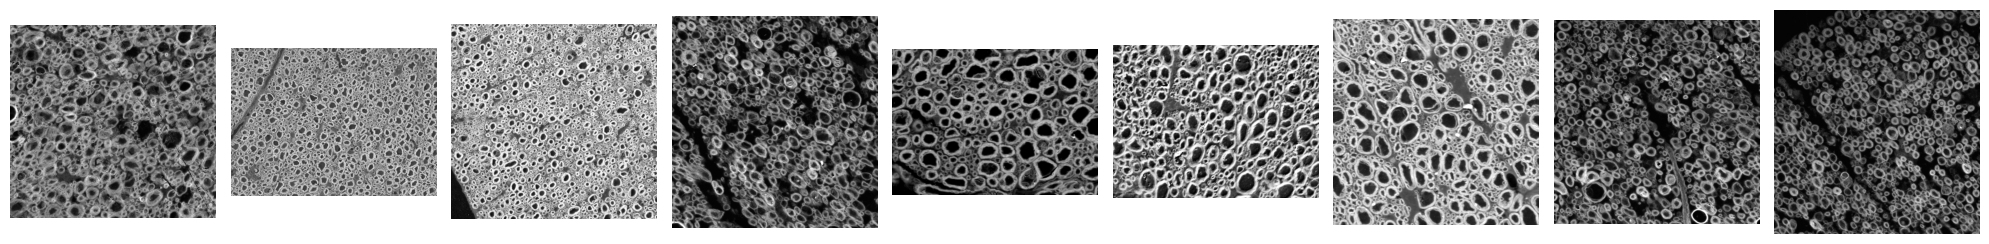

In [36]:
show_input_files(input_images_paths)
map_inputs = create_map_inputs(uploaded_files, input_metadata_paths)

In [13]:
map = tools.maps.oSparcFileMap(input1_dir_path/'output_tasks.json', output1_dir_path/'input_tasks.json')
map_outputs = map.evaluate(map_inputs)
map_outputs_file_path.write_text(json.dumps(map_outputs))

5607

In [37]:
map_outputs = json.loads(map_outputs_file_path.read_text())

In [38]:
map_outputs = process_map_outputs(map_outputs)

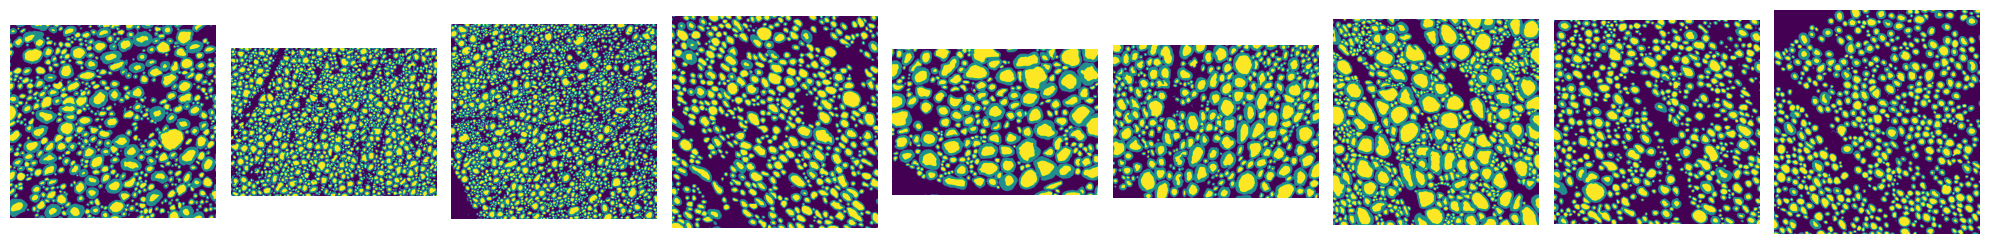

In [39]:
show_output_files(map_outputs, input_images_paths)

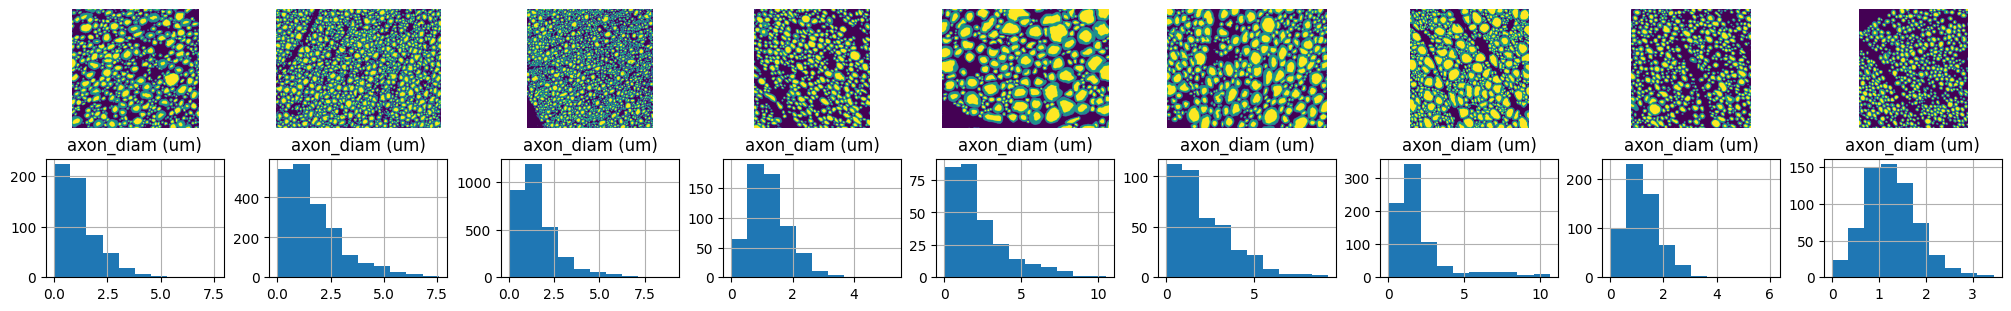

In [83]:
requested_morphometrics = ['axon_diam (um)']
fig, axes = plt.subplots(2, len(map_outputs), squeeze=False, figsize=(20,3), layout="constrained")
for map_output, input_image_path, ax in zip(map_outputs, input_images_paths, axes.transpose()):
    with zipfile.ZipFile(map_output['ProcessedImage']) as output_zip:
        processed_filename = f'{input_image_path.stem}_seg-axonmyelin{input_image_path.suffix}'
        with output_zip.open(processed_filename) as image_file:
            ax[0].imshow(mpimg.imread(image_file))
            ax[0].axis('off')
            ax[0].autoscale(False)
    
    morphometrics_file = map_output['Morphometrics']
    morphometrics = pandas.read_csv(morphometrics_file)
    
    for i_ax, morphometric in enumerate(requested_morphometrics):
        morphometrics.hist(column='axon_diam (um)', ax=ax[1])
        ax[i_ax].set_title('')
        #ax[i_ax].suptitle(morphometric)
    
plt.show()